# Code for experiments with colored MNIST and Celeba

## 1. Imports

In [1]:
import os, sys
sys.path.append("..")

from src.enot import SDE, integrate, make_net

import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
import torch
torch.set_num_threads(64)
import torch.nn as nn
import torchvision
import gc
import pdb

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.cunet import CUNet
from src.improved_diffusion import UNetModel

from src.tools import unfreeze, freeze
from src.tools import load_dataset, get_sde_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.tools import weights_init_D
from src.plotters import plot_random_sde_images, plot_fixed_sde_images, plot_fixed_sde_trajectories, plot_random_sde_trajectories, plot_several_fixed_sde_trajectories, plot_several_random_sde_trajectories

from collections import defaultdict
from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

import math
import gc
import wandb
import json
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

from eot_benchmark.image_benchmark import ImageBenchmark

## 2. ENOT Config

In [2]:
# Choose epsilon here
EPSILON = 10

# For Celeba exps
DATASET1, DATASET1_PATH = 'CelebA_noise_eps_1', ''
DATASET2, DATASET2_PATH = 'CelebA', ''

# N steps in the Euler-Maruyama
N_STEPS = 10

# GPU choosing
DEVICE_IDS = [0]
GPU_DEVICE = 0

# All hyperparameters below is set to the values used for the experiments, which discribed in the article

T_ITERS = 10
D_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64
UNET_BASE_FACTOR = 48

TIME_DIM = 128
CONSTANT_TIME = False
USE_POSITIONAL_ENCODING = True
RESNET_GENERATOR = False
INTEGRAL_SCALE = 1/(3*IMG_SIZE*IMG_SIZE)
ONE_STEP_INIT_ITERS = 0
T_GRADIENT_MAX_NORM = float("inf")
D_GRADIENT_MAX_NORM = float("inf")
PREDICT_SHIFT = True
SMART_INTERVALS = False
INTERVAL_SHRINK_START_TIME = 0.98
LAST_STEP_NOISE_STD = 1e-3
USE_GRADIENT_CHECKPOINT = False
PREDICT_NOISE_AT_LAST_STEP = False
N_LAST_STEPS_WITHOUT_NOISE = 1
TRACK_VAR_INTERVAL = 10
IMPROVED_DIFFUSION = False
USE_CHECKPOINTS_INSIDE_MODEL = False
EPSILON_SCHEDULER_LAST_ITER = 20000
USE_EXPONENTIAL_AVERAGE_MODEL = False
DISTINCT_SHIFT_MODELS = False
IMAGE_INPUT = True

DATASET1_CHANNELS = 3
DATASET2_CHANNELS = 3
GRAY_PLOTS = False
BATCH_SIZE = 16
STEPS_TO_SHOW = 10

PLOT_INTERVAL = 500
COST = 'schrodinger'
CPKT_INTERVAL = 500
MAX_STEPS = 100001
SEED = 0xBADBEEF

GAMMA0, GAMMA1 = 0.0, 0.333
GAMMA_ITERS = 20000

In [3]:
T = CUNet(DATASET1_CHANNELS, DATASET2_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR).cuda()

T = SDE(shift_model=T, epsilon=EPSILON, n_steps=N_STEPS,
        time_dim=TIME_DIM, n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
        use_positional_encoding=USE_POSITIONAL_ENCODING,
        use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
        predict_shift=PREDICT_SHIFT, image_input=IMAGE_INPUT).cuda()

T.load_state_dict(torch.load(f"../image_enot_checkpoints/ENOT_{EPSILON}.pt"))

<All keys matched successfully>

In [4]:
benchmark = ImageBenchmark(batch_size=20, eps=EPSILON, glow_device=f"cuda:{GPU_DEVICE}",
                           samples_device=f"cuda:{GPU_DEVICE}", download=False)

Y_sampler = benchmark.Y_sampler

In [5]:
y_samples = Y_sampler.sample(10)

enot_predictions = T(y_samples)[0][:, -1].detach().cpu()

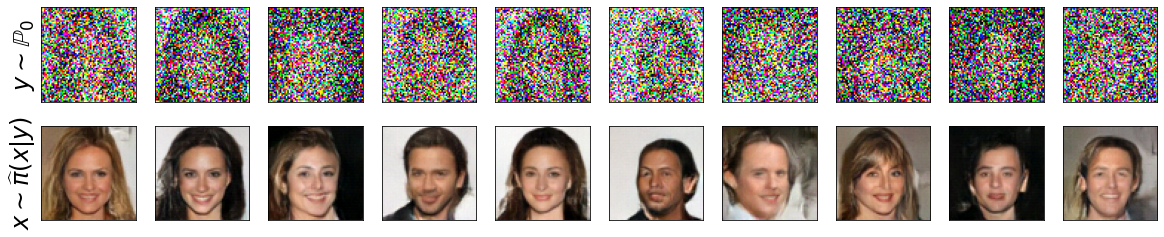

In [6]:
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(2):
    for j in range(10):
        ax = axes[i,j]
        if i == 0:
            ax.imshow((y_samples[j].cpu().permute(1, 2, 0)*0.5 + 0.5).clip(0, 1))
        elif i== 1:
            ax.imshow((enot_predictions[j].cpu().permute(1, 2, 0)*0.5 + 0.5).clip(0, 1))
            
        if j == 0:
            if i == 0:
                ax.set_ylabel(r"$y \sim \mathbb{P}_0$", fontsize=24)
            if i == 1:
                ax.set_ylabel(r"$x \sim \widehat{\pi}(x|y)$", fontsize=24)
            
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])